# **Pneumonia Detection**

In [ ]:
#!pip install tensorflow==2.0.0
#!pip install keras==2.3.1

In [ ]:
import pandas as pd 
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tqdm
from tqdm import tqdm_notebook
from matplotlib.patches import Rectangle
import seaborn as sns
!pip install pydicom
import pydicom as dcm
%matplotlib inline 
IS_LOCAL = False

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Load Datasets**

In [ ]:
detailclassinfo_df = pd.read_csv('../input/rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv')
trainlabels_df = pd.read_csv('../input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')

In [ ]:
detailclassinfo_df.head()

In [ ]:
trainlabels_df.head()

In [ ]:
print('Shape of Detailed Class Information: {}'.format(detailclassinfo_df.shape))
print('Shape of Train Labels: {}'.format(trainlabels_df.shape))

# **Exploratory Data Analysis**

**Data Preprocessing**

Merging Datasets

In [ ]:
merge_train_df = trainlabels_df.merge(detailclassinfo_df, left_on='patientId', right_on='patientId', how='inner')
merge_train_df.sample(5)

In [ ]:
merge_train_df = merge_train_df. drop_duplicates()
merge_train_df.shape

**Summary on the values, types and null values**

In [ ]:
merge_train_df.isnull().sum()

**Inference**: Bounding box parameters x, y , width and height are having Null/NaN values

**Distribution of classes**

In [ ]:
detailclassinfo_df.groupby(["class"]).count().transpose().style.background_gradient(cmap='Wistia',axis=1)

In [ ]:
merge_train_df.groupby(["class"]).count().transpose().style.background_gradient(cmap='Wistia',axis=1)

**Inference**: 9555 patients are in class of 'Lung Opacity', 11821 are in 'No Lung Opacity / Not Normal' and 8851 are in Normal category.

In [ ]:
f, ax = plt.subplots(1,1, figsize=(6,4))
total = float(len(merge_train_df))
sns.countplot(merge_train_df['class'],order = merge_train_df['class'].value_counts().index, palette='Set1')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(100*height/total),
            ha="center") 
plt.show()

**Insight**: The classes "No Lung Opacity / Not Normal", "Lung Opacity" and "Normal" are in the proportions of 39%, 32% and 29% respectively

**Distribution of Labels (Positive and Negative)**

In [ ]:
f, ax = plt.subplots(1,1, figsize=(6,4))
sns.countplot(x = "Target", data= merge_train_df, hue="class", palette='Set1')

In [ ]:
plt.style.use('ggplot')
f, ax = plt.subplots(1,1, figsize=(6,4))
totale = float(len(merge_train_df))
pd.value_counts(merge_train_df["Target"]).plot(kind='bar', position=0.5, rot=0)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(100*height/total),
            ha="center") 
plt.show()

In [ ]:
# Number of positive targets
print(round((9555 / (9555 + 20672)) * 100, 2), '% of the patients are positive')

In [ ]:
merge_train_df.groupby(["Target"]).count()

**Insight**: 

1. Patients with Target = 0 (no pathology detected) are either of class: Normal or class: No Lung Opacity / Not Normal don't have bounding box coordinates (x, y, w, h) parameters.
2. **31.61%** of the patients belongs to **Lung Opacity** class.

**Handling Null using KNN Imputation method**

In [ ]:
merge_bb_df = merge_train_df.drop(columns = ["patientId", "class"])

## Impute NaN with KNN mean
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)
merge_bb_imputed_df = imputer.fit_transform(merge_bb_df)

## Converted array to dataframe
merge_bb_final = pd.DataFrame(data=merge_bb_imputed_df, columns=["x", "y", "width", "height", "Target"])
merge_bb_final["Target"] = merge_bb_final["Target"].astype('int64')
merge_bb_final.head(5)

In [ ]:
# Seggregating Opacity data from imputed data
opacity_bb_final = merge_bb_final[(merge_bb_final['Target']== 1)]
opacity_bb_final.head()

**Checking Data Distribution**

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(12,12))
sns.distplot(opacity_bb_final['x'],kde=True,bins=50, color="grey", ax=ax[0,0])
sns.distplot(opacity_bb_final['y'],kde=True,bins=50, color="orange", ax=ax[0,1])
sns.distplot(opacity_bb_final['width'],kde=True,bins=50, color="blue", ax=ax[1,0])
sns.distplot(opacity_bb_final['height'],kde=True,bins=50, color="brown", ax=ax[1,1])
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

**Finding Correlation**

In [ ]:
# Correlation
plt.figure(figsize=(7,5))
sns.heatmap(opacity_bb_final.corr(),linewidths=0.1,vmax=1.0, 
            square=True,  linecolor='white', annot=True)
plt.show()

In [ ]:
sns.jointplot(x = 'width', y = 'height', data = opacity_bb_final, kind= 'reg')

**Inference**: There is a fine correlation between width and height variables.

**Lung Opacity Representation** (2000 samples)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
target_sample = opacity_bb_final.sample(2000)
target_sample['xc'] = target_sample['x'] + target_sample['width'] / 2
target_sample['yc'] = target_sample['y'] + target_sample['height'] / 2
plt.title("Lung Opacity representation for 2000 data samples")
target_sample.plot.scatter(x='xc', y='yc', xlim=(0,1024), ylim=(0,1024), ax=ax, alpha=0.8, marker=".", color="black")
for i, crt_sample in target_sample.iterrows():
    ax.add_patch(Rectangle(xy=(crt_sample['x'], crt_sample['y']),
                width=crt_sample['width'],height=crt_sample['height'],alpha=3.5e-3, color="green"))
plt.show()

**Split Data sets** (Train= 80%, Test= 20%)

In [ ]:
tmp = merge_train_df[["patientId", "class"]]
train_labels_data = pd.merge(tmp, merge_bb_final, how= 'inner', left_index=True, right_index=True)
train_labels_data.head()

In [ ]:
X = train_labels_data.drop(columns= ["patientId", "Target", "class"])
y = train_labels_data[["Target"]]
X.shape, y.shape

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, average_precision_score
from sklearn.metrics import roc_auc_score, auc, plot_confusion_matrix, plot_roc_curve, roc_curve

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =7)
print('Training data shape:', (X_train.shape, y_train.shape))
print('Test data shape:', (X_test.shape, y_test.shape))

# **Classification using SVC**

In [ ]:
from sklearn.svm import SVC
svm_model = SVC(kernel = 'rbf', C = 1.0).fit(X_train, y_train)
y_preds = svm_model.predict(X_test)
print('Accuracy score:', accuracy_score(y_test, y_preds))
print('Average Precision Score:', average_precision_score(y_test, y_preds))

In [ ]:
print('Score: "{:.2%}"'.format(svm_model.score(X, y)))

In [ ]:
print('Classification report: \n')
print(classification_report(y_test, y_preds))

In [ ]:
plot_confusion_matrix(svm_model, X_test, y_test, values_format='d', cmap ='plasma')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
plot_roc_curve(svm_model, X_test, y_test, name= 'ROC-TP/FP')

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_preds)

# calculate AUC
auc = roc_auc_score(y_test, y_preds)
print('AUC: %.3f' % auc)

# **Using Pydicom to analyze .dcm images**

Medical images are stored in DICOM file format (.DCM). 
In python pydicom library is used to manipulate these kind of files.

**Load DICOM data**

In [ ]:
patientId = trainlabels_df['patientId'][0]
dcm_file = '../input/rsna-pneumonia-detection-challenge/stage_2_train_images/%s.dcm' % patientId
dcm_data = dcm.read_file(dcm_file)
print(dcm_data)

In [ ]:
im = dcm_data.pixel_array
print(type(im))
print(im.dtype)
print(im.shape)

**Visualize sample image**

In [ ]:
import pylab
pylab.imshow(im, cmap=pylab.cm.gist_gray)
pylab.axis('off')


# **Plot bounding boxes over Images**

In [ ]:
def parse_data(df):
    """
    Method to read a CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:

      parsed = {
        
        'patientId-00': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        },
        'patientId-01': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        }, ...

      }

    """
    # --- Define lambda to extract coords in list [y, x, height, width]
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': '../input/rsna-pneumonia-detection-challenge/stage_2_train_images/%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []}

        # --- Add box if opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

parsed = parse_data(trainlabels_df)

def draw(data):
    """
    Method to draw single patient with bounding box(es) if present 

    """
    # --- Open DICOM file
    d = dcm.read_file(data['dicom'])
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # --- Add boxes with random color if present
    for box in data['boxes']:
        #rgb = np.floor(np.random.rand(3) * 256).astype('int')
        rgb = [0, 0, 255] # Just use blue
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=15)

    plt.imshow(im, cmap=plt.cm.gist_gray)
    plt.axis('off')

def overlay_box(im, box, rgb, stroke=2):
    """
    Method to overlay single box on image

    """
    # --- Convert coordinates to integers
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

**Visualize Train Labels dataset images**

In [ ]:
plt.style.use('default')
fig=plt.figure(figsize=(8, 8))
columns = 5; rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    draw(parsed[trainlabels_df['patientId'].unique()[i]])
    fig.add_subplot

**Visualize Detail Class dataset images**

In [ ]:
opacity = detailclassinfo_df \
    .loc[detailclassinfo_df['class'] == 'Lung Opacity'] \
    .reset_index()

In [ ]:
not_normal = detailclassinfo_df \
    .loc[detailclassinfo_df['class'] == 'No Lung Opacity / Not Normal'] \
    .reset_index()

In [ ]:
normal = detailclassinfo_df \
    .loc[detailclassinfo_df['class'] == 'Normal'] \
    .reset_index()

**1. Lung Opacity Samples**

In [ ]:
plt.style.use('default')
fig=plt.figure(figsize=(6, 6))
columns = 4; rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    draw(parsed[opacity['patientId'].unique()[i]])

**2. Normal Samples**

In [ ]:
plt.style.use('default')
fig=plt.figure(figsize=(6, 6))
columns = 4; rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    draw(parsed[normal['patientId'].unique()[i]])

**3. No Lung Opacity/Not Normal Samples**

In [ ]:
plt.style.use('default')
fig=plt.figure(figsize=(6, 6))
columns = 4; rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    draw(parsed[not_normal['patientId'].unique()[i]])

In [ ]:
fig=plt.figure(figsize=(20, 10))
columns = 3; rows = 1
fig.add_subplot(rows, columns, 1).set_title("Normal", fontsize=30)
draw(parsed[normal['patientId'].unique()[0]])
fig.add_subplot(rows, columns, 2).set_title("Not Normal", fontsize=30)
# ax2.set_title("Not Normal", fontsize=30)
draw(parsed[not_normal['patientId'].unique()[0]])
fig.add_subplot(rows, columns, 3).set_title("Opacity", fontsize=30)
# ax3.set_title("Opacity", fontsize=30)
draw(parsed[opacity['patientId'].unique()[0]])

# **Image Segmentation**

**Image segmentation** creates a pixel-wise mask for each object in the image. This technique gives us a far more granular understanding of the object(s) in the image.

Class generatortransfer:

The dataset is too large to fit into memory, so we need to create a generator that loads data on the fly.

**I/p**: filenames, batch_size and other parameters.

**O/p**: A random batch of numpy images and numpy masks.

# **Model Selection**

In [ ]:
import os
import csv
import random
import pydicom
import numpy as np
import pandas as pd
from skimage import measure
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras

**Load opacity locations**

In [ ]:
opacity_locations = {}
# load table
with open(os.path.join('../input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        lungopacity = rows[5]
        # if row contains lungopacity add label to dictionary
        # which contains a list of lungopacity locations per filename
        if lungopacity == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save lungopacity location in dictionary
            if filename in opacity_locations:
                opacity_locations[filename].append(location)
            else:
                opacity_locations[filename] = [location]

**Load File names**

In [ ]:
folder = '../input/rsna-pneumonia-detection-challenge/stage_2_train_images'
filenames = os.listdir(folder)
print('Number of Train images:', len(filenames))
print('First 5 samples: \n')
filenames[0:5]

In [ ]:
#folder = '/content/drive/My Drive/GL_Capstone/stage_2_train_images'
#filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 5336
n_train_samples = len(filenames) - n_valid_samples
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('Total file samples:', len(filenames))
print('Train samples (80%):', len(train_filenames))
print('Valid samples (20%):', len(valid_filenames))

**Downsampling Train samples**

In [ ]:
n_downsamples = 5336
train_dsamps = train_filenames[:n_downsamples]
print('Training Downsamples:', len(train_dsamps))

# **Transfer Learning**

In [ ]:
!pip install opencv-python
import cv2
keras = tf.compat.v1.keras
#Sequence = keras.utils.Sequence

**Define class generatortransfer**

In [ ]:
class generatortransfer(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, opacity_locations=None, batch_size=32, image_size=320, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.opacity_locations = opacity_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains lung opacity
        if filename in opacity_locations:
            # loop through opacity
            for location in opacity_locations[filename]:
                # add 1's at the location of the lung opacity
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # resize both image and mask
        #img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # add trailing channel dimension
        msk = np.expand_dims(msk, -1)
         #Converting Image from GrayScale to RGB 
        if len(img.shape) != 3 or img.shape[2] != 3:
            img = np.stack((img,) * 3, -1)
            img = cv2.resize(img, dsize=(self.image_size, self.image_size), interpolation=cv2.INTER_CUBIC)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        #img = resize(img, (self.image_size, self.image_size), mode='reflect')
        #Converting Image from GrayScale to RGB 
        if len(img.shape) != 3 or img.shape[2] != 3:
          img = np.stack((img,) * 3, -1)
          img = cv2.resize(img, dsize=(self.image_size, self.image_size), interpolation=cv2.INTER_CUBIC)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [ ]:
img_width = 128
img_height = 128
IMAGE_SIZE=128
kernel =3
num_of_classes =2
BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE=1000
#input_shape = (img_width, img_height, 3)

In [ ]:
# create training and validation data
folder = '../input/rsna-pneumonia-detection-challenge/stage_2_train_images'
train_trans = generatortransfer(folder, train_filenames, opacity_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=False, predict=False)
valid_trans = generatortransfer(folder, valid_filenames, opacity_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=False)
#train_downsamples = generatortransfer(folder, tune_train_samples, opacity_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=False)

In [ ]:
import keras
from tensorflow.keras import Sequential, backend as K
#from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Concatenate, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(ResNet50(input_shape= (img_width, img_height, 3), include_top=False, weights='imagenet'))
model.add(Dense(1024, activation='relu'))
model.add(UpSampling2D())
model.add(Dense(512, activation='relu'))
model.add(UpSampling2D())
model.add(Dense(256, activation='relu'))
model.add(UpSampling2D())
model.add(Dense(64, activation='relu'))
model.add(UpSampling2D())
model.add(Dense(8, activation='relu'))
model.add(UpSampling2D())
model.add(Dense(1, activation='sigmoid'))
# Say not to train first layer (ResNet) model. It is already trained
model.layers[0].trainable = False
print(model.summary())

In [ ]:
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_trans, epochs=5, steps_per_epoch =10, shuffle=True)

In [ ]:
model.evaluate(valid_trans)

# **Hyper Parameter Tuning**

I have tried couple of times to use GridSearchCV in order to find out the optimal parameters, but the session ran for longer time and the runtime was disconnected and finally lead to lost of changes.

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
#!pip install tensorflow==1.14.0
#!pip install keras==2.0

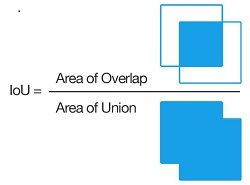

**IoU Mean**

In [ ]:
# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

**Call Backs (Earlystop, ModelCheckpoint)**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
## Earlystopping
earlystop = EarlyStopping(monitor='val_loss', patience=3)

## Model Check point
filepath="/kaggle/working/LOHPT-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only = True)

## Reduce learning rate when metric has stopped improving
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, 
                                   patience=2, verbose=1, mode='auto', 
                                   epsilon=0.0001, cooldown=5, min_lr=0.0001)

 **Define Parameters**

In [ ]:
BATCH_SIZE = 16
IMAGE_SIZE = 128

In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras import Sequential, backend as K
#from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Concatenate, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

hpt_model = Sequential()
hpt_model.add(ResNet50(input_shape= (img_width, img_height, 3), include_top=False, weights='imagenet'))
hpt_model.add(Dense(1024, activation='relu'))
hpt_model.add(UpSampling2D())
hpt_model.add(Dense(512, activation='relu'))
hpt_model.add(UpSampling2D())
hpt_model.add(Dense(256, activation='relu'))
hpt_model.add(UpSampling2D())
hpt_model.add(Dense(64, activation='relu'))
hpt_model.add(UpSampling2D())
hpt_model.add(Dense(8, activation='relu'))
hpt_model.add(UpSampling2D())
hpt_model.add(Dense(1, activation='sigmoid'))
# Say not to train first layer (ResNet) model. It is already trained
hpt_model.layers[0].trainable = False
print(hpt_model.summary())

**Compilation**

In [ ]:
hpt_model.compile(optimizer= 'Adam',
              loss='binary_crossentropy',
              metrics=['accuracy', mean_iou])

**Fitting Model**

In [ ]:
#history = hpt_model.fit(train_trans, validation_data= valid_trans, 
                        #epochs=10, callbacks=[earlystop, checkpoint, reduceLROnPlat],
                        #steps_per_epoch=10, shuffle=True)

# **Plots for Accuracy, Loss, IoU Mean**

**Accuracy**

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy Graph')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Loss**

In [ ]:
Train_Loss = history.history['loss']
Val_Loss = history.history['val_loss']
Epochs = range(1, len(Train_Loss) + 1)
plt.plot(Epochs, Train_Loss, 'r', label='Training Loss')
plt.plot(Epochs, Val_Loss, 'g', label='Validation Loss')
plt.title('Training and Validation Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**iou_mean**

In [ ]:
train_iou = history.history['mean_iou']
val_iou = history.history['val_mean_iou']
epochs = range(1, len(train_iou) + 1)
plt.plot(epochs, train_iou, 'r', label='Training iou')
plt.plot(epochs, val_iou, 'g', label='Validation iou')
plt.title('Training and Validation IOU Graph')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

**Load the model weights**

In [ ]:
model.save_weights('/kaggle/working/RESNET50-05-0.97.hdf5')

# **Predict Test images**

In [ ]:
# load and shuffle filenames
#folder = '../input/stage_2_test_images'
folder = '../input/rsna-pneumonia-detection-challenge/stage_2_test_images'
test_filenames = os.listdir(folder)
print('n test samples:', len(test_filenames))

In [ ]:
# create test generator with predict flag set to True
test_trans = generatortransfer(folder, test_filenames, None, batch_size=16, image_size=IMAGE_SIZE, shuffle=False, predict=True)

In [ ]:
test_dicom_dir = '../input/rsna-pneumonia-detection-challenge/stage_2_test_images'

In [ ]:
import glob
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

In [ ]:
# Get filenames of test dataset DICOM images
test_image_fps = get_dicom_fps(test_dicom_dir)

In [ ]:
# Make predictions on test images, write out sample submission 
def predict(image_fps, filepath='/content/sample_submission.csv', min_conf=0.98): 
    
    # assume square image
    
    with open(filepath, 'w') as file:
      for image_id in tqdm_notebook(image_fps): 
        ds = dcm.read_file(image_id)
        image = ds.pixel_array
          
        # If grayscale. Convert to RGB for consistency.
        #if len(image.shape) != 3 or image.shape[2] != 3:

        image = np.stack((image,) * 3, -1)
        #img = cv2.resize(image, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)


        #patient_id = os.path.splitext(os.path.basename(image_fps))[0]
        patient_id = image_fps
        results = hpt_model.predict([image])
        r = results[0]

        out_str = ""
        out_str += patient_id 
        assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
        if len(r['rois']) == 0: 
            pass
        else: 
            num_instances = len(r['rois'])
            out_str += ","
            for i in range(num_instances): 
                if r['scores'][i] > min_conf: 
                    out_str += ' '
                    out_str += str(round(r['scores'][i], 2))
                    out_str += ' '

                    # x1, y1, width, height 
                    x1 = r['rois'][i][1]
                    y1 = r['rois'][i][0]
                    width = r['rois'][i][3] - x1 
                    height = r['rois'][i][2] - y1 
                    bboxes_str = "{} {} {} {}".format(x1, y1, \
                                                      width, height)    
                    out_str += bboxes_str

        filepath.write(out_str+"\n")

In [ ]:
# predict only the first 50 entries
sample_submission_fp = '/kaggle/working/sample_submission.csv'
predict(test_image_fps[:50], filepath=sample_submission_fp)